# US Stock Market EDA

**Описание задачи:**

У нас в распоряжении набор данных с фондового рынка США, нам предстоит предсказать стоимость активов на следующую неделю.

##### **Содержание:**
- [Описание данныx](#1)
- [Очистка данных](#2)
- [Отбор активов](#3)
- [Тренд, сезонность, шум](#4)
- [Cкользящее среднее, и отклонение стандартного среднего ](#5)
- [Подготовка данных для обучения](#6)
- [CatBoost](#7)
- [LightGBM](#8)
- [XGBRegressor](#9)
- [Тестирование](#10)

**Описание данных:** <a id='1'></a>

В данном проекте буду использовать набор данных с [Kaggle](https://www.kaggle.com/datasets/saketk511/2019-2024-us-stock-market-data/data), который  предоставляет всестороннее представление о фондовом рынке США, включая различные сырьевые товары, криптовалюты и основные акции. Данные обновляются ежедневно и охватывают период примерно в один месяц. На момент анализа данные содержат финансовые данные  за период с 1 января 2020 года по 26 января 2024 года. 



**Набор данных включает следующие столбцы (39):**

- Date
- Natural Gas Price **end** Natural Gas Vol. - цена и объемы природного газа
- Crude Oil Price **end** Crude Oil Vol. - цена и объемы на сырую нефть
- Copper Price **end** Copper Vol. - цена и объемы на медь
- Bitcoin Price **end** Bitcoin Vol. - цена и объемы биткоина
- Platinum Price **end** Platinum Vol. - цена и объемы платины
- Ethereum Price **end** Ethereum Vol. - цена и объемы Эфириума
- S&P 500 Price - цена на S&P 500
- Nasdaq 100 Price **end** Nasdaq 100 Vol. - цена и объемы Nasdaq 100
- Apple Price **end** Apple Vol. - цена и объемы Apple
- Tesla Price **end** Tesla Vol. - цена и объемы Tesla
- Microsoft Price **end** Microsoft Vol. - цена и объемы Microsoft
- Silver Price **end** Silver Vol. - цена и объемы серебра
- Google Price **end** Google Vol. - цена и объемы Google
- Nvidia Price **end** Nvidia Vol. - цена и объемы Nvidia
- Berkshire Price **end** Berkshire Vol. - цена и объемы Berkshire
- Netflix Price **end** Netflix Vol. - цена и объемы Netflix
- Amazon Price **end** Amazon Vol. - цена и объемы Amazon
- Meta Price **end** Meta Vol. - цена и объемы металла
- Gold Price **end** Gold Vol. - цена и объемы золота
- Bitcoin Price (5 Minute) **end** Bitcoin Vol. (5 Minute) - цена и объемы биткоина (5 минут)

Загрузим библиотеки необходимые для работы с данными и сами данные: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import warnings
import time
import lightgbm as lgbm
import catboost as cb
warnings.filterwarnings("ignore")

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import kurtosis
from scipy.signal import find_peaks
from statsmodels.iolib.table import SimpleTable
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from statsmodels. tsa.stattools import adfuller
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

### Работа с данными, устранение ошибок и установка индекса даты <a id='2'></a>

In [3]:
path = 'US Stock Market Dataset.csv'

try:
    stock_market = pd.read_csv(path)
except FileNotFoundError:
    print(f"Запрашиваемый файл {path} не найден")

In [4]:
stock_market.head()

,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
0,0,2/2/2024,2.079,NaN,72.28,NaN,3.8215,NaN,"43,194.70",42650,...,"5,89,498",10580,564.64,4030000,171.81,117220000,474.99,84710000,"2,053.70",NaN
1,1,1/2/2024,2.050,161340.0,73.82,577940.0,3.8535,NaN,"43,081.40",47690,...,"5,81,600",9780,567.51,3150000,159.28,66360000,394.78,25140000,"2,071.10",260920.0
2,2,31-01-2024,2.100,142860.0,75.85,344490.0,3.9060,NaN,"42,580.50",56480,...,"5,78,020",9720,564.11,4830000,155.20,49690000,390.14,20010000,"2,067.40",238370.0
3,3,30-01-2024,2.077,139750.0,77.82,347240.0,3.9110,NaN,"42,946.20",55130,...,"5,84,680",9750,562.85,6120000,159.00,42290000,400.06,18610000,"2,050.90",214590.0
4,4,29-01-2024,2.490,3590.0,76.78,331930.0,3.8790,NaN,"43,299.80",45230,...,"5,78,800",13850,575.79,6880000,161.26,42840000,401.02,17790000,"2,034.90",1780.0


В колонке с датой разный формат записи дат и поэтому её необходимо привести к однотипному, чтобы потом преобразовать в формат datetime. Предлагаю заменить косую черту на дефис.

In [5]:
stock_market['Date'][:20].values

array(['2/2/2024', '1/2/2024', '31-01-2024', '30-01-2024', '29-01-2024',
       '26-01-2024', '25-01-2024', '24-01-2024', '23-01-2024',
       '22-01-2024', '19-01-2024', '18-01-2024', '17-01-2024',
       '16-01-2024', '12/1/2024', '11/1/2024', '10/1/2024', '9/1/2024',
       '8/1/2024', '5/1/2024'], dtype=object)

In [6]:
stock_market=stock_market.iloc[:,1:]
for i in range(len(stock_market)):
    if '/' in stock_market.loc[i,'Date']:
        d,m,y=stock_market.loc[i,'Date'].split('/')
        stock_market.loc[i,'Date']=y+'-'+m.zfill(2)+'-'+d.zfill(2)

In [7]:
stock_market['Date']

0       2024-02-02
1       2024-02-01
2       31-01-2024
3       30-01-2024
4       29-01-2024
           ...    
1008    2020-01-08
1009    2020-01-07
1010    2020-01-06
1011    2020-01-03
1012    2020-01-02
Name: Date, Length: 1013, dtype: object

Преобразую верный тип, чтобы использовать временные данные:

In [8]:
for index in range(len(stock_market)):
    try:
        stock_market.loc[index,'Date'] = pd.to_datetime(stock_market.loc[index, 'Date'],  dayfirst=False)
    except:
        print(index, stock_market.loc[index, 'Date'])

In [9]:
stock_market['Date']

0       2024-02-02 00:00:00
1       2024-02-01 00:00:00
2       2024-01-31 00:00:00
3       2024-01-30 00:00:00
4       2024-01-29 00:00:00
               ...         
1008    2020-01-08 00:00:00
1009    2020-01-07 00:00:00
1010    2020-01-06 00:00:00
1011    2020-01-03 00:00:00
1012    2020-01-02 00:00:00
Name: Date, Length: 1013, dtype: object

P.s. после замены знаков и преобразования в тип datetime в документации нашла парамент dayfirst=False - указывает порядок синтаксического анализа даты, если arg имеет значение str или похож на список. Если True, то даты анализируются в европейском стиле (т.е. строка с датой начинается с указания дня). То есть строка даты '10/11/24' будет анализироваться как 2024-11-10.. Вопрос к тебе): можно было наверное и без преобразования сразу бросить всё в преобразование pd.to_datetime с  указанием dayfirst=True, верные мысли приходят после. Убрать обработку выше с заменой символов и перестановкой дней, месяцев и года или пусть уже как есть?

Поставим дату в индекс датафрейма:

In [10]:
stock_market = stock_market.iloc[::-1]

In [11]:
stock_market = stock_market.set_index('Date').asfreq('d')

In [12]:
stock_market.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-27',
               '2024-01-28', '2024-01-29', '2024-01-30', '2024-01-31',
               '2024-02-01', '2024-02-02'],
              dtype='datetime64[ns]', name='Date', length=1493, freq='D')

In [13]:
stock_market.sort_index(inplace=True)

In [14]:
stock_market.index.min(), stock_market.index.max()

(Timestamp('2020-01-02 00:00:00'), Timestamp('2024-02-02 00:00:00'))

Посмотрим на общую информацию:

In [15]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1493 entries, 2020-01-02 to 2024-02-02
Freq: D
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Natural_Gas_Price  1013 non-null   float64
 1   Natural_Gas_Vol.   1009 non-null   float64
 2   Crude_oil_Price    1013 non-null   float64
 3   Crude_oil_Vol.     990 non-null    float64
 4   Copper_Price       1013 non-null   float64
 5   Copper_Vol.        976 non-null    float64
 6   Bitcoin_Price      1013 non-null   object 
 7   Bitcoin_Vol.       1013 non-null   float64
 8   Platinum_Price     1013 non-null   object 
 9   Platinum_Vol.      636 non-null    float64
 10  Ethereum_Price     1013 non-null   object 
 11  Ethereum_Vol.      1013 non-null   float64
 12  S&P_500_Price      1013 non-null   object 
 13  Nasdaq_100_Price   1013 non-null   object 
 14  Nasdaq_100_Vol.    1012 non-null   float64
 15  Apple_Price        1013 non-null   float64
 16

В данных есть пропуски, колонки представлены однотипными данными - это объём фондового продукта и его стоимость. Считаю верным разделить объём от цен и рассматривать их в анализе в отдельности. Также в данных присутствуют не верные типы данных для числовых данных -  object что связано с дополнительными символами в строковых записях, их тоже стоит обработать.

создадим список с колонками типа object чтобы провести замену знаков в ценах и преобразовать в формат float:

In [16]:
col_object = stock_market.select_dtypes(include=['object']).columns
col_object.tolist()

['Bitcoin_Price',
 'Platinum_Price',
 'Ethereum_Price',
 'S&P_500_Price',
 'Nasdaq_100_Price',
 'Berkshire_Price',
 'Gold_Price']

In [17]:
for col in col_object:
    stock_market[col] = stock_market[col].apply(lambda x: float(str(x).replace(",", "")))

In [18]:
stock_market[col_object].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1493 entries, 2020-01-02 to 2024-02-02
Freq: D
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Bitcoin_Price     1013 non-null   float64
 1   Platinum_Price    1013 non-null   float64
 2   Ethereum_Price    1013 non-null   float64
 3   S&P_500_Price     1013 non-null   float64
 4   Nasdaq_100_Price  1013 non-null   float64
 5   Berkshire_Price   1013 non-null   float64
 6   Gold_Price        1013 non-null   float64
dtypes: float64(7)
memory usage: 93.3 KB


In [19]:
# Определяю колонки с символами 'Vol' в названии
columns_with_vol = stock_market.filter(like='Vol').columns
pd.DataFrame(round(stock_market[columns_with_vol].isna().mean()*100,3)).style.background_gradient('coolwarm')

,0
Natural_Gas_Vol.,32.418000
Crude_oil_Vol.,33.691000
Copper_Vol.,34.628000
Bitcoin_Vol.,32.150000
Platinum_Vol.,57.401000
Ethereum_Vol.,32.150000
Nasdaq_100_Vol.,32.217000
Apple_Vol.,32.150000
Tesla_Vol.,32.150000
Microsoft_Vol.,32.150000


In [20]:
# Определяю колонки с символами 'Price' в названии
columns_with_price = stock_market.filter(like='Price').columns
pd.DataFrame(round(stock_market[columns_with_price].isna().mean()*100,3)).style.background_gradient('coolwarm')

,0
Natural_Gas_Price,32.150000
Crude_oil_Price,32.150000
Copper_Price,32.150000
Bitcoin_Price,32.150000
Platinum_Price,32.150000
Ethereum_Price,32.150000
S&P_500_Price,32.150000
Nasdaq_100_Price,32.150000
Apple_Price,32.150000
Tesla_Price,32.150000


После семплирования данных по дням у нас появились пропуски в данных, которые возможно заполнить  предыдущим и последующим значениями. Но минус этого способа в том, что они могут внести систематическую ошибку, особенно если заполнять таким образом несколько пропусков подряд. Например, предположим, что в данных есть тренд, а мы шесть из двенадцати месяцев заполнили одним значением (константой). Как следствие, тренд был удален из данных.

Указанную проблему можно попытаться решить через параметр limit, который ограничивает количество последовательно заполняемых одним и тем же значением пропусков. Другими словами, если пропущено четыре значения подряд, а limit установлен на уровне двух, предыдущим либо последующим наблюдением будут заполены только два из четырех значени Есть и другие варианты заполнения, например скользящим средним и медианой и  способ линейной или полиномиальной интерполяции в дальнейшем возможно стоит рассмотреть.й.

Есть ещё один способ заполнить пропуски, интерполировать значения nan для заполнения между двумя значениями, предполагая, что между этими двумя точками наблюдается устойчивый рост или спад

In [21]:
stock_market =  stock_market.interpolate()

Посчитаю описательные статистики по данным предварительно преобразовав необходимые колонки к числовым значениям

In [22]:
display(stock_market[columns_with_vol].describe().round())
stock_market[columns_with_vol].describe().round().loc[['mean', '50%']]

,Natural_Gas_Vol.,Crude_oil_Vol.,Copper_Vol.,Bitcoin_Vol.,Platinum_Vol.,Ethereum_Vol.,Nasdaq_100_Vol.,Apple_Vol.,Tesla_Vol.,Microsoft_Vol.,Silver_Vol.,Google_Vol.,Nvidia_Vol.,Berkshire_Vol.,Netflix_Vol.,Amazon_Vol.,Meta_Vol.,Gold_Vol.
count,1493.0,1493.0,1493.0,1.493000e+03,1279.0,1.493000e+03,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0
mean,127998.0,349766.0,37345.0,4.776752e+07,10913.0,1.938087e+07,237795599.0,98580995.0,132724752.0,30293788.0,61755.0,34109779.0,46395991.0,2973.0,6892900.0,75165137.0,24755717.0,187827.0
std,61671.0,183770.0,38181.0,3.128716e+08,9019.0,1.428666e+08,84420030.0,55066171.0,84769123.0,12605140.0,37616.0,14159908.0,18528072.0,2790.0,6249892.0,33480056.0,15164810.0,101507.0
min,1200.0,17020.0,10.0,2.600000e+02,0.0,7.518000e+04,68570000.0,24040000.0,29400000.0,9200000.0,0.0,9310000.0,9790000.0,120.0,1140000.0,21620000.0,5470000.0,0.0
25%,89130.0,268480.0,442.0,7.248000e+04,1759.0,5.336530e+05,185040000.0,63176667.0,78916667.0,22460000.0,44030.0,24826667.0,34110000.0,750.0,3796667.0,52110000.0,16200000.0,142920.0
50%,124062.0,340817.0,38000.0,1.297070e+05,10887.0,9.818100e+05,224623333.0,84180000.0,107020000.0,27110000.0,58275.0,30750000.0,43800000.0,2040.0,5390000.0,66130000.0,21320000.0,180210.0
75%,164650.0,414555.0,69450.0,3.828600e+05,18530.0,3.670000e+06,264980000.0,115540000.0,157850000.0,34153333.0,73780.0,38860000.0,56180000.0,4170.0,7860000.0,87760000.0,28710000.0,229020.0
max,381970.0,1770000.0,176040.0,4.470000e+09,42830.0,1.790000e+09,982560000.0,426880000.0,914080000.0,97070000.0,355280.0,123200000.0,153460000.0,13850.0,133390000.0,311350000.0,230410000.0,813410.0


,Natural_Gas_Vol.,Crude_oil_Vol.,Copper_Vol.,Bitcoin_Vol.,Platinum_Vol.,Ethereum_Vol.,Nasdaq_100_Vol.,Apple_Vol.,Tesla_Vol.,Microsoft_Vol.,Silver_Vol.,Google_Vol.,Nvidia_Vol.,Berkshire_Vol.,Netflix_Vol.,Amazon_Vol.,Meta_Vol.,Gold_Vol.
mean,127998.0,349766.0,37345.0,47767525.0,10913.0,19380871.0,237795599.0,98580995.0,132724752.0,30293788.0,61755.0,34109779.0,46395991.0,2973.0,6892900.0,75165137.0,24755717.0,187827.0
50%,124062.0,340817.0,38000.0,129707.0,10887.0,981810.0,224623333.0,84180000.0,107020000.0,27110000.0,58275.0,30750000.0,43800000.0,2040.0,5390000.0,66130000.0,21320000.0,180210.0


Статистики однородны почти для всех ценных продуктов фонда кроме криптовалюты, их рост сильно заметен в разнице среднего и медианного значения. Биткоин в настоящее время имеет стремительную тенденцию к росту, эфир тоже на писке роста, поэтому данные отличия не являются выбросами в данных. (P.s. Нынешний рынок  создает условия для роста стоимости биткоина и капитализации крипторынка в целом. Идёт устойчивый спрос на спотовые биткоин-ETF и это позитивно влияет на их ликвидность. Это делает их активы более привлекательными для тех инвесторов, кто не готовы былт инвестировать в эти ETF на старте, желая сначала понаблюдать за первыми результатами торгов. Таким образом, рост спроса на биткоин увеличивается за счет новых инвесторов и оказывает поддержку крипторынку.

Помимо роста объема покупок со стороны институциональных игроков биткоин практически не сталкивается с давлением продаж со стороны майнеров и крупных игрокоО объемы продаж со стороны майнеров не растут, а количество кошельков с крупными балансами в биткоинах, наоборот, растет высокими темпами. Это свидетельствует не только о нежелании участников рынка продавать криптовалюту по текущим ценам, но и о готовности формировать длинные позиции по текущим ценам — довольно высоким относительно начала год)om=copy

In [23]:
display(stock_market[columns_with_price].describe().round())
stock_market[columns_with_price].describe().round().loc[['mean', '50%']]

,Natural_Gas_Price,Crude_oil_Price,Copper_Price,Bitcoin_Price,Platinum_Price,Ethereum_Price,S&P_500_Price,Nasdaq_100_Price,Apple_Price,Tesla_Price,Microsoft_Price,Silver_Price,Google_Price,Nvidia_Price,Berkshire_Price,Netflix_Price,Amazon_Price,Meta_Price,Gold_Price
count,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0,1493.0
mean,4.0,70.0,4.0,29210.0,979.0,1731.0,3987.0,13017.0,142.0,209.0,266.0,23.0,109.0,219.0,424529.0,422.0,138.0,252.0,1839.0
std,2.0,22.0,1.0,15069.0,108.0,1098.0,532.0,2234.0,34.0,85.0,57.0,3.0,25.0,128.0,82321.0,120.0,27.0,73.0,118.0
min,1.0,-38.0,2.0,4826.0,595.0,108.0,2237.0,6994.0,56.0,24.0,135.0,12.0,53.0,49.0,240000.0,166.0,82.0,89.0,1478.0
25%,2.0,54.0,3.0,17164.0,911.0,1059.0,3695.0,11577.0,125.0,163.0,223.0,21.0,88.0,132.0,349200.0,339.0,114.0,195.0,1764.0
50%,3.0,73.0,4.0,27603.0,971.0,1715.0,4105.0,13063.0,146.0,223.0,261.0,23.0,111.0,178.0,431718.0,432.0,143.0,262.0,1836.0
75%,5.0,83.0,4.0,40888.0,1038.0,2316.0,4400.0,14891.0,168.0,262.0,308.0,25.0,132.0,272.0,480280.0,510.0,161.0,313.0,1936.0
max,10.0,124.0,5.0,67528.0,1297.0,4808.0,4959.0,17643.0,198.0,410.0,411.0,29.0,154.0,662.0,589498.0,692.0,187.0,475.0,2090.0


,Natural_Gas_Price,Crude_oil_Price,Copper_Price,Bitcoin_Price,Platinum_Price,Ethereum_Price,S&P_500_Price,Nasdaq_100_Price,Apple_Price,Tesla_Price,Microsoft_Price,Silver_Price,Google_Price,Nvidia_Price,Berkshire_Price,Netflix_Price,Amazon_Price,Meta_Price,Gold_Price
mean,4.0,70.0,4.0,29210.0,979.0,1731.0,3987.0,13017.0,142.0,209.0,266.0,23.0,109.0,219.0,424529.0,422.0,138.0,252.0,1839.0
50%,3.0,73.0,4.0,27603.0,971.0,1715.0,4105.0,13063.0,146.0,223.0,261.0,23.0,111.0,178.0,431718.0,432.0,143.0,262.0,1836.0


В ценах не наблюдаются стремительные тенденции, данные однородны и не имеют выбросов, следует построить временные графики и посмотреть на тенденции на предоставленных за данный промежуток времени. На данный момент анализируя данные задачи временного ряда думаю можно рассматривать её как для прогнозирования цен на  ценные продукты фондового рынка, так и для предсказания роста или снижения их объемов.  В данном проекте передо мной стоит цель предсказания цен на фондовом рынке, поэтому буду брать её за основную.

### Отбор активов <a id='3'></a>

Будем работать с определёнными продуктами: биткоин, эфириум, Apple, Tesla, Google, Nvidia,золото.

'Bitcoin Price', 'Ethereum Price', 'Apple Price', 'Tesla Price', 'Google Price', 'Nvidia Price', 'Gold Price'

In [24]:
col_sort = ['Bitcoin_Price', 'Ethereum_Price', 'Apple_Price', 'Tesla_Price', 'Google_Price', 'Nvidia_Price', 'Gold_Price']
stock_market_seven = stock_market[col_sort]
stock_market_seven.head()

,Bitcoin_Price,Ethereum_Price,Apple_Price,Tesla_Price,Google_Price,Nvidia_Price,Gold_Price
Date,,,,,,,
2020-01-02,6967.000000,127.19,75.090000,28.68,68.430000,59.980000,1528.100000
2020-01-03,7343.100000,134.27,74.360000,29.53,68.080000,59.020000,1552.400000
2020-01-04,7481.766667,137.54,74.556667,29.72,68.683333,59.103333,1557.866667
2020-01-05,7620.433333,140.81,74.753333,29.91,69.286667,59.186667,1563.333333
2020-01-06,7759.100000,144.08,74.950000,30.10,69.890000,59.270000,1568.800000


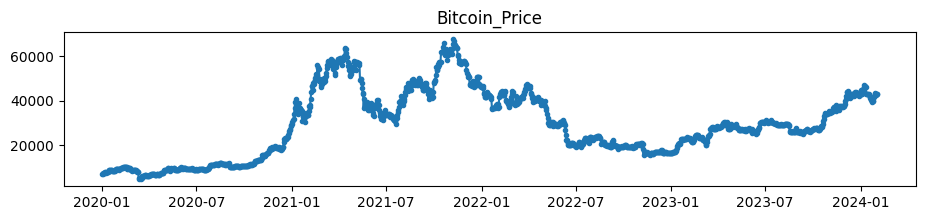

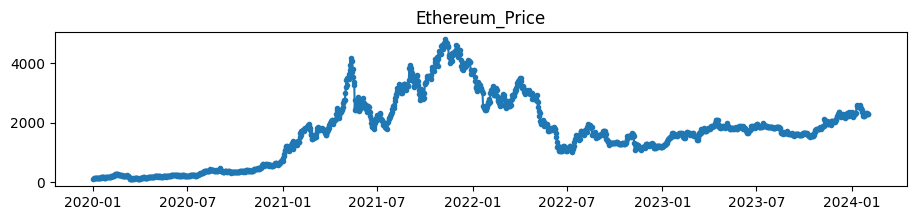

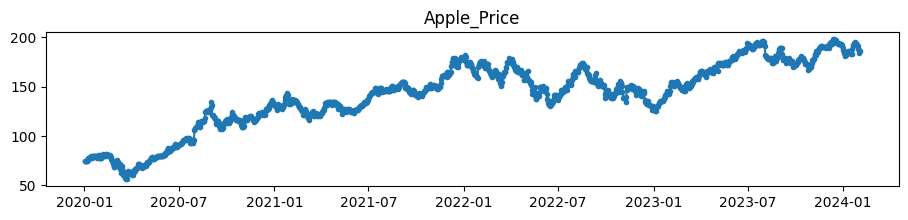

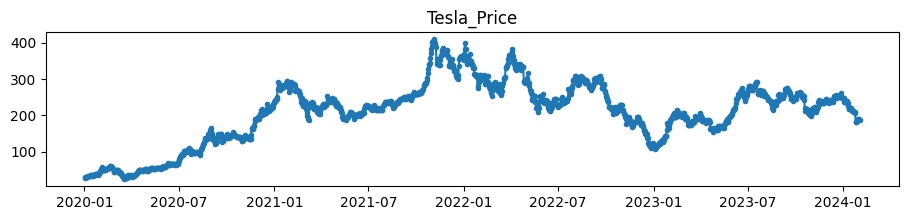

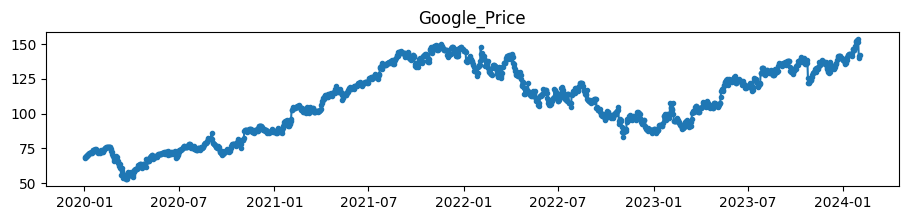

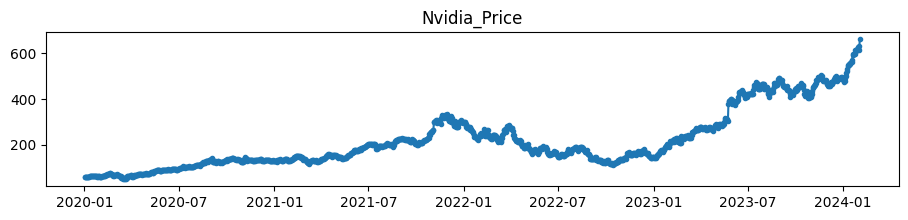

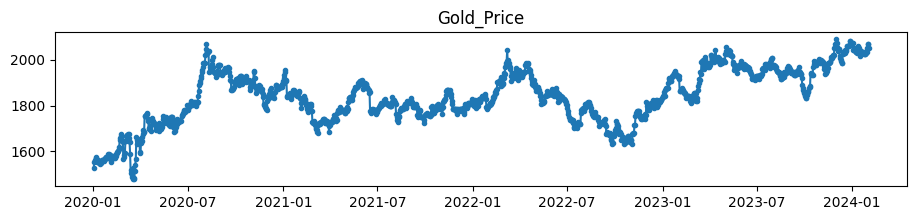

In [25]:
for col in stock_market_seven.columns:
    plt.figure(figsize=(11,2))
    plt.plot(stock_market_seven[col], marker='o', markersize=3) 
    plt.title(col)
    plt.show()

начиная с начала 2023 года наблюдается в графиках тенденция к росту. Сильные колебания для криптовалюты были в 2021-2022 годах, наблюдается как рост так и резкое падение цен. Выберем временной промежуток в последних 2 месяца  (скорректируй  если это не так и следует пересмотерть это) так как фондовый рынок сильно подвержен порой и часовым и более коротким изменениям. Воспользуемся библиотекой statsmodels и отобразим на графиках, тренд, сезонность и шумы по активам:

### Тренд, сезонность, шум <a id='4'></a>

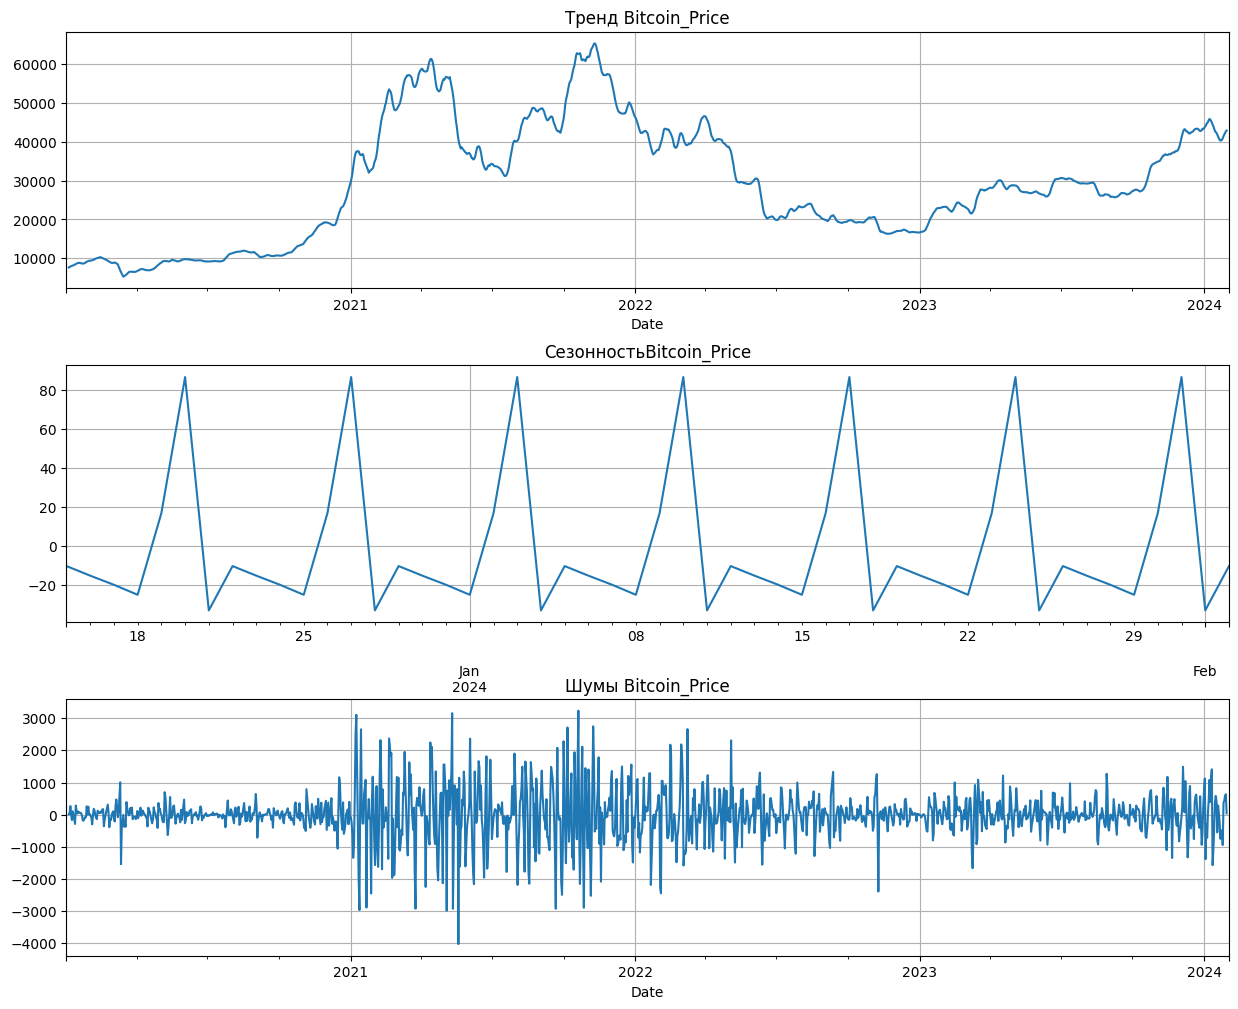

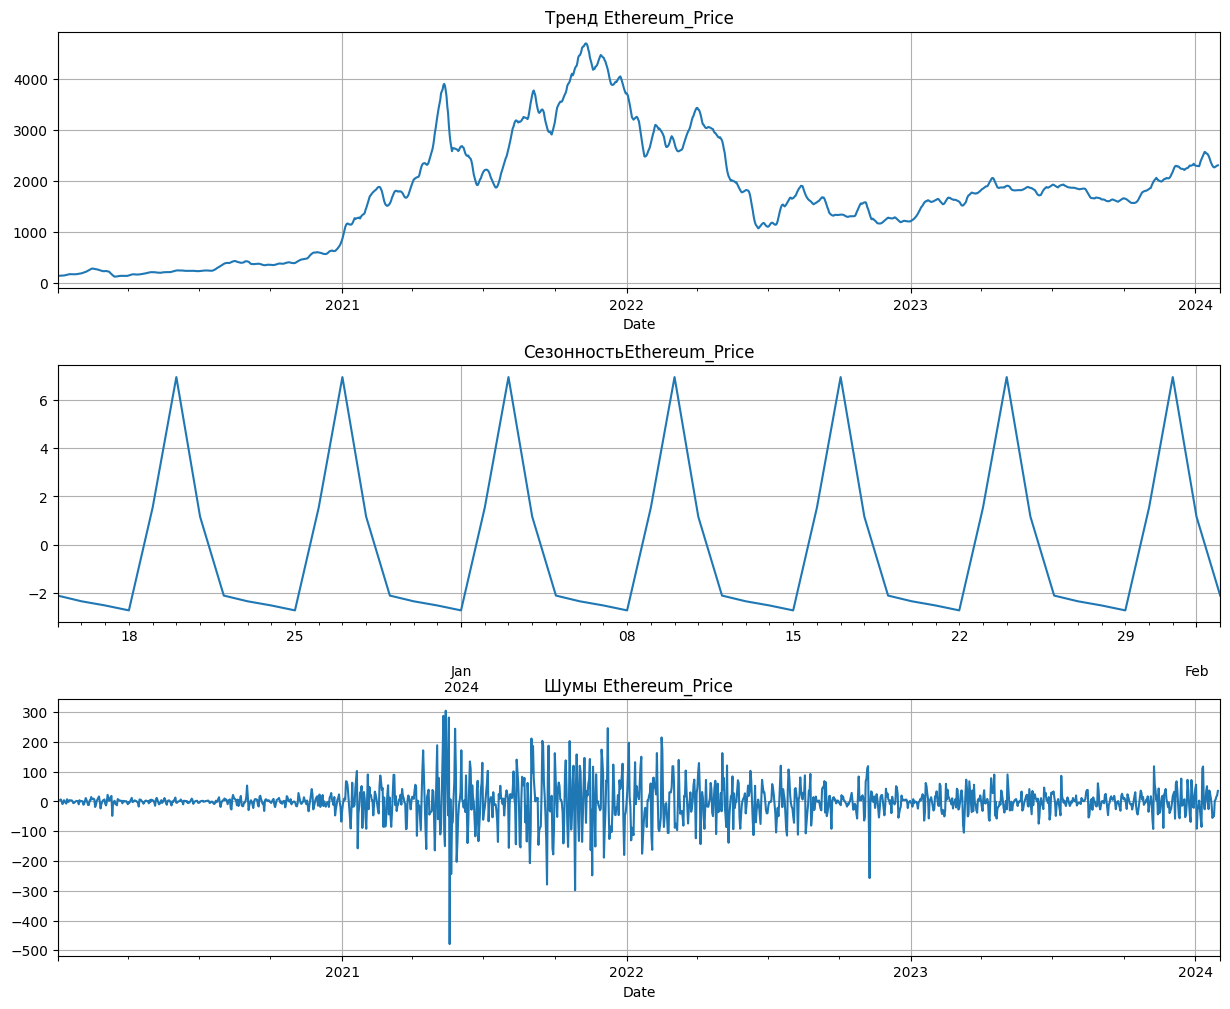

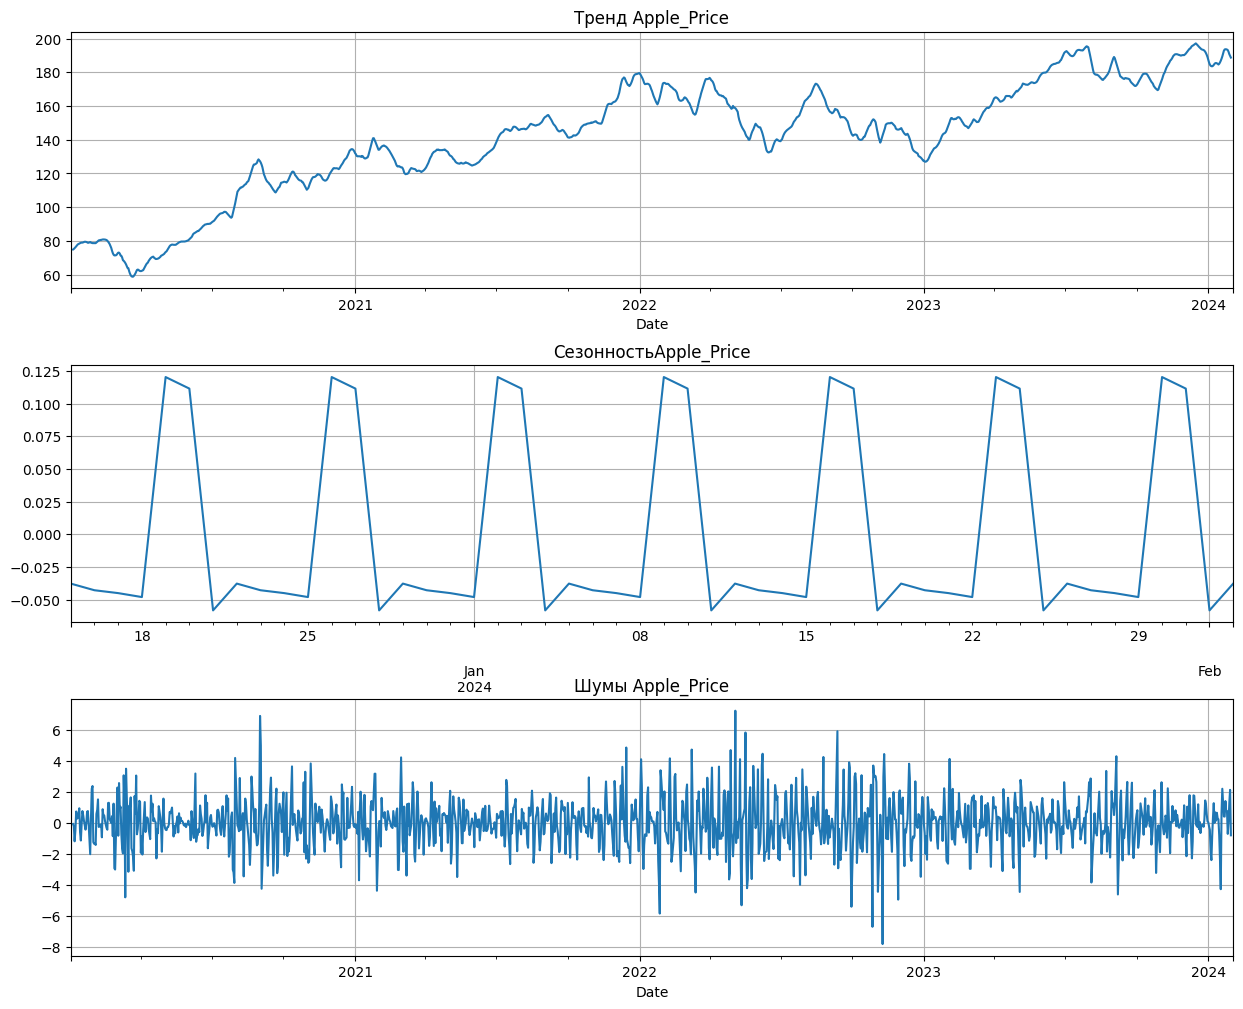

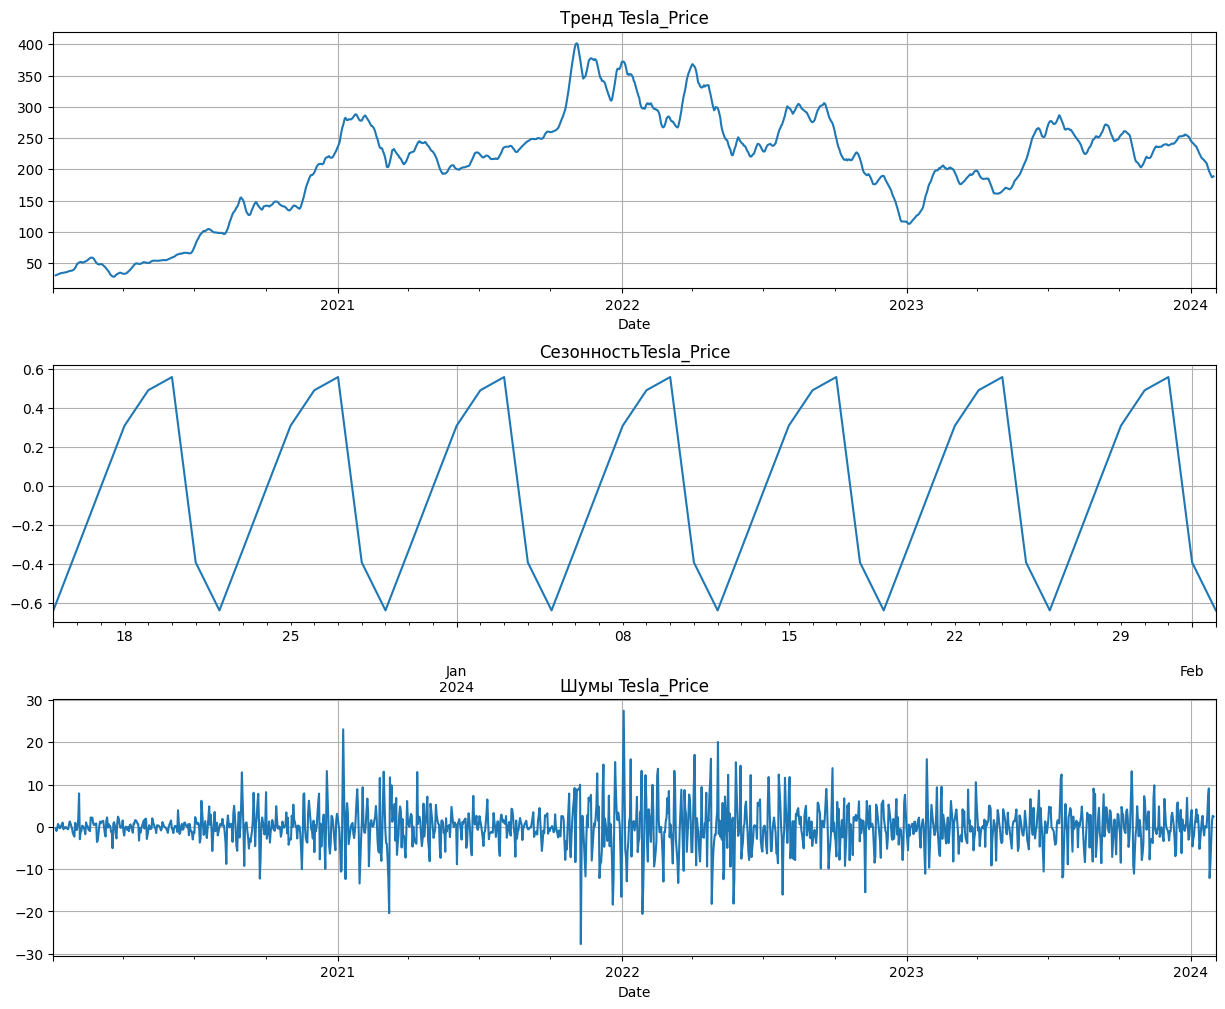

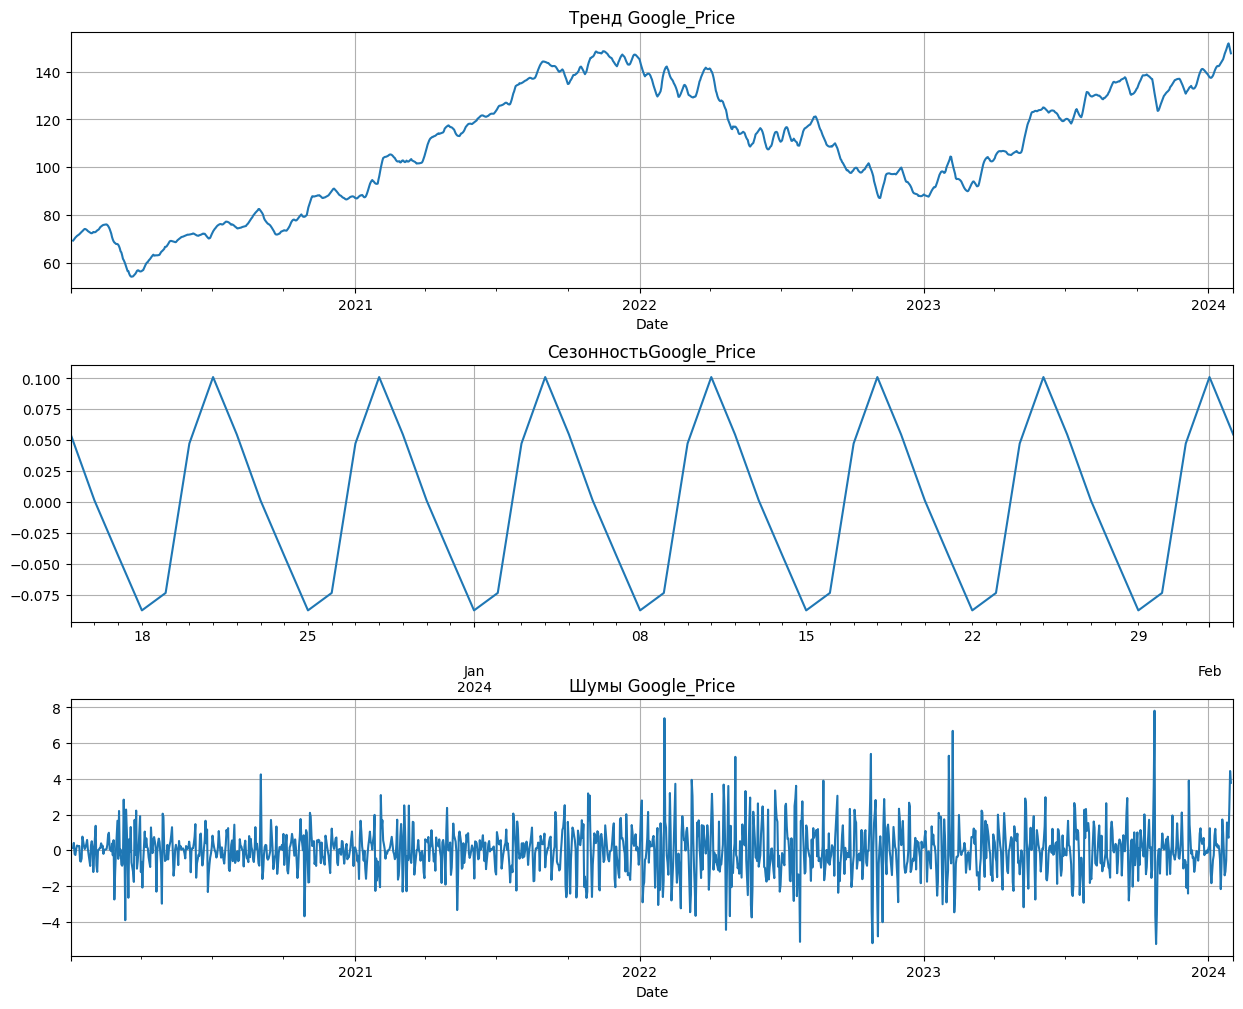

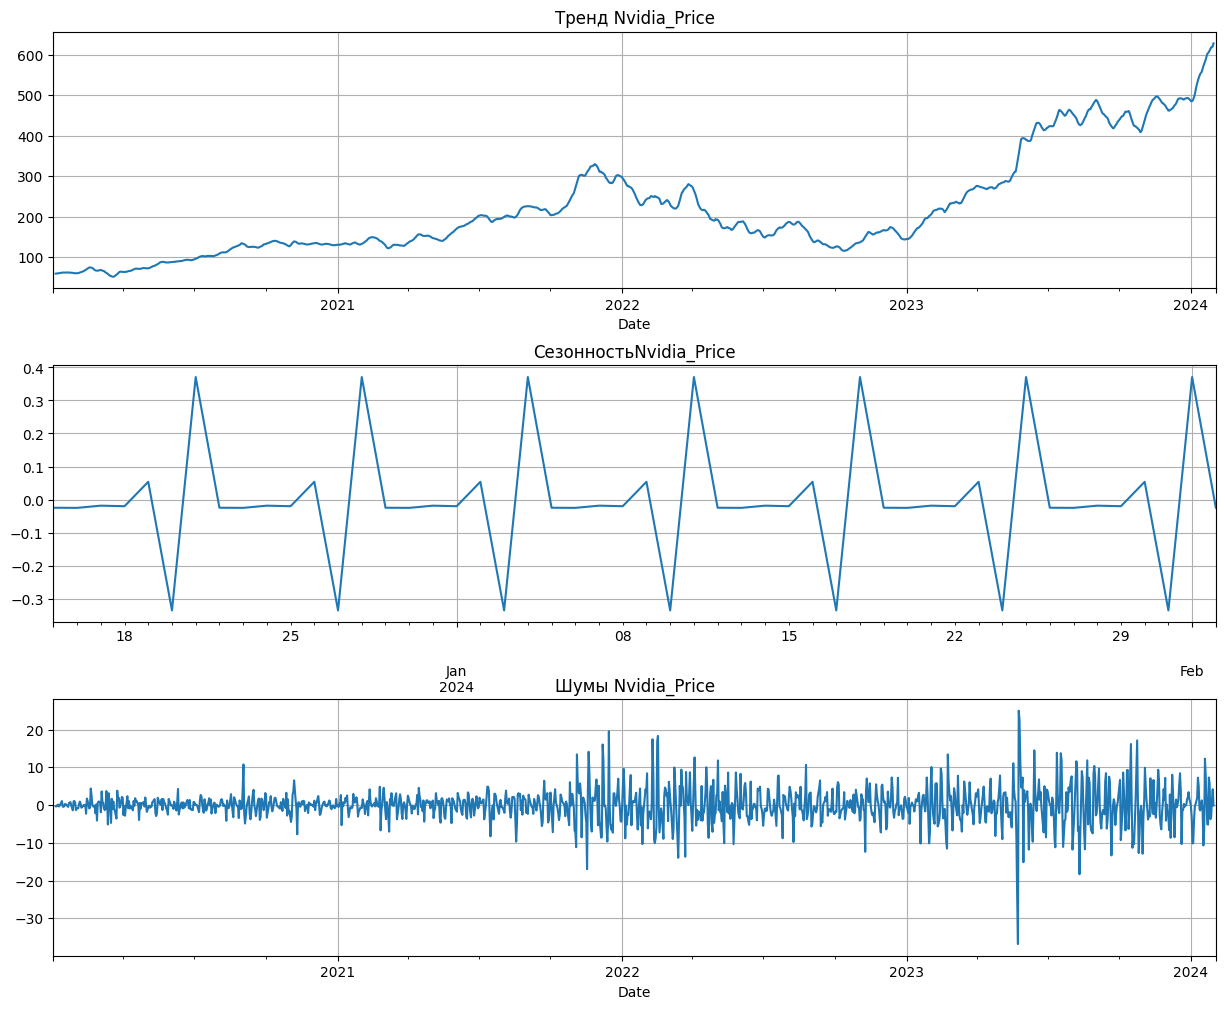

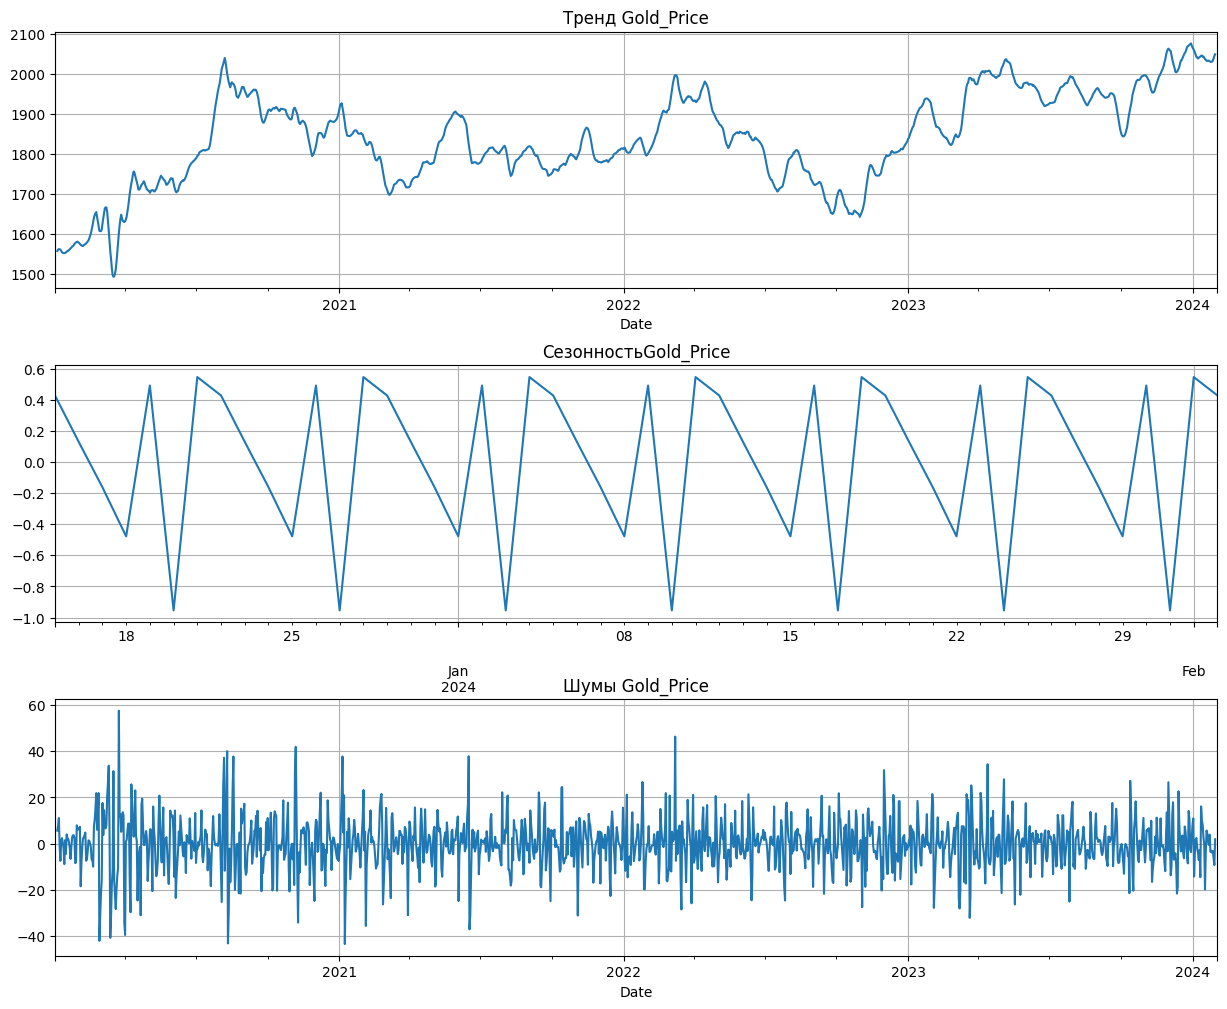

In [26]:
for col in stock_market_seven.columns:
    decomposed  = seasonal_decompose(stock_market_seven[col])
    fig, ax = plt.subplots(3, 1, figsize=(15,12))
    plt.subplots_adjust(hspace=0.3)
    
    decomposed.trend.plot(ax=ax[0], title=f'Тренд {col}', grid=True)
    decomposed.seasonal.tail(50).plot(ax=ax[1], title=f'Сезонность{col}', grid=True)
    decomposed.resid.plot(ax=ax[2], title=f'Шумы {col}', grid=True);

В данных имеется недельная сезонность, цены за этот промежуток более однороднее растут у Nvidia. Тренд на этом промежутке времени имеет тенденцию как к увеличению так и к уменьшению.

### Cкользящее среднее, и отклонение стандартного среднего <a id='5'></a>

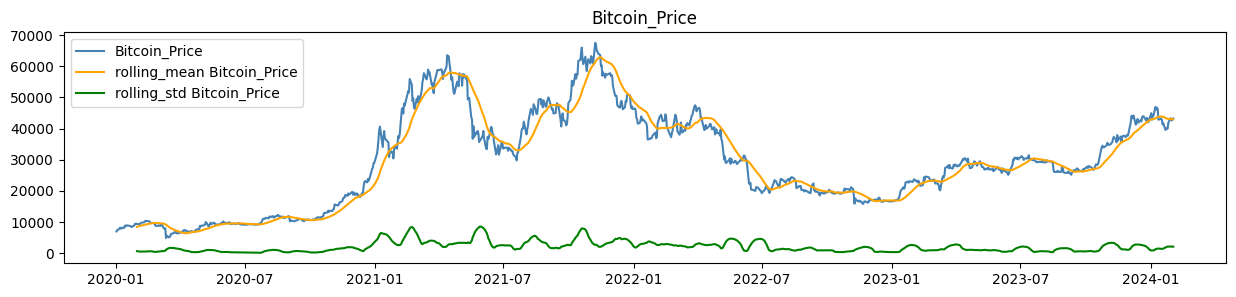

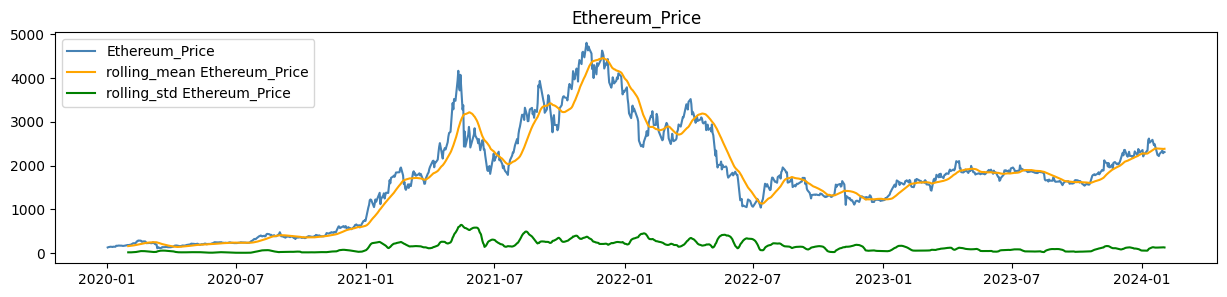

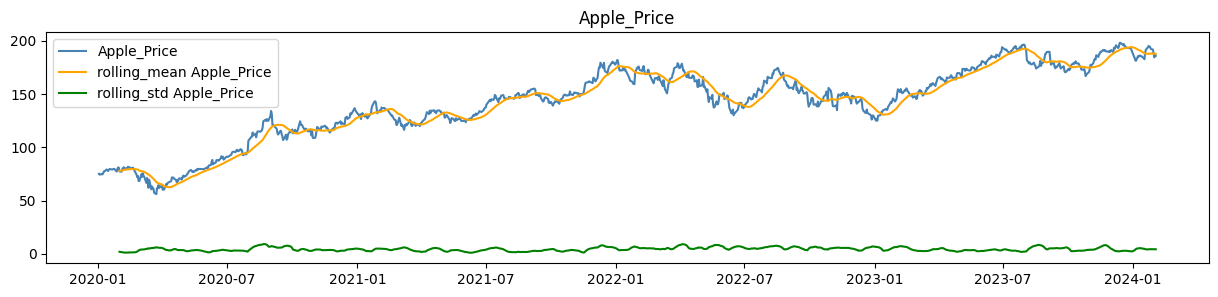

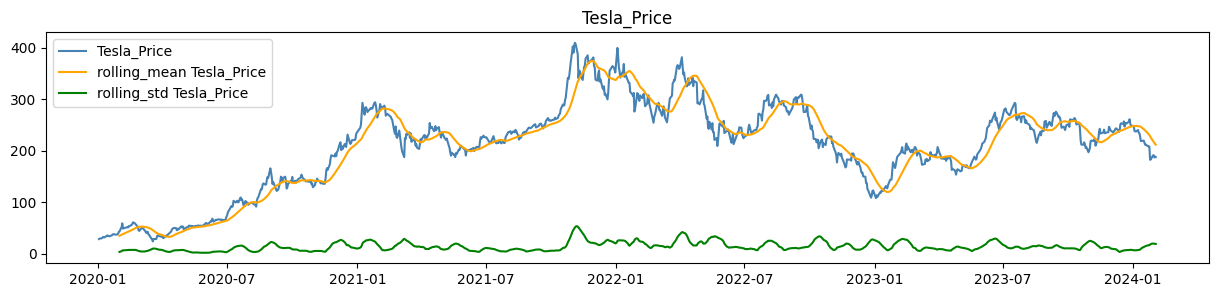

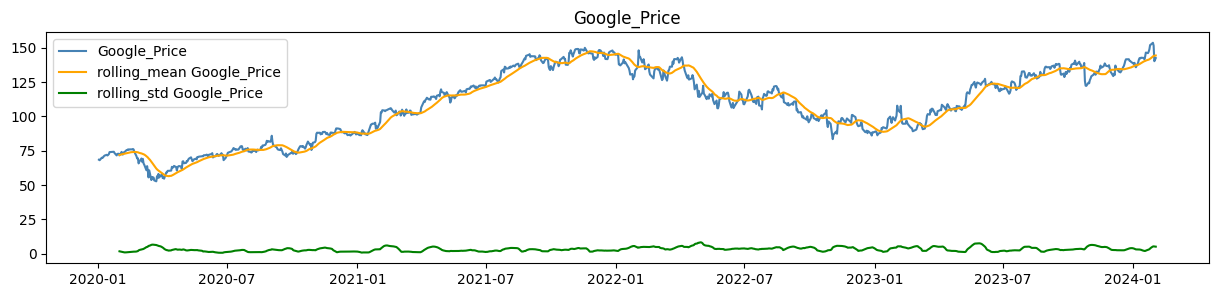

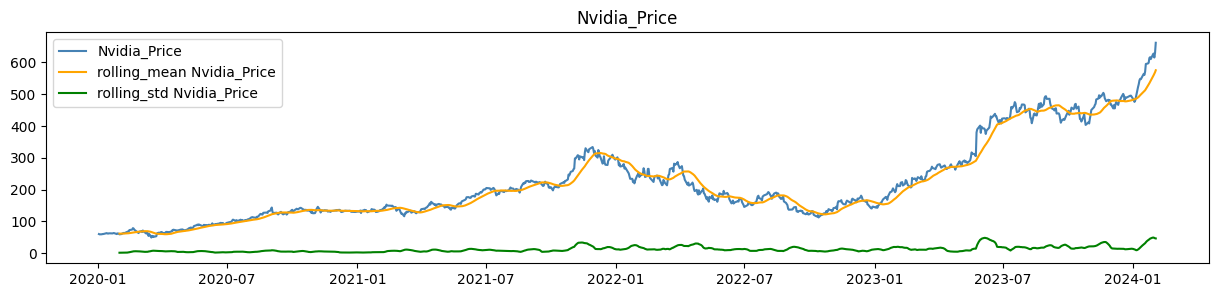

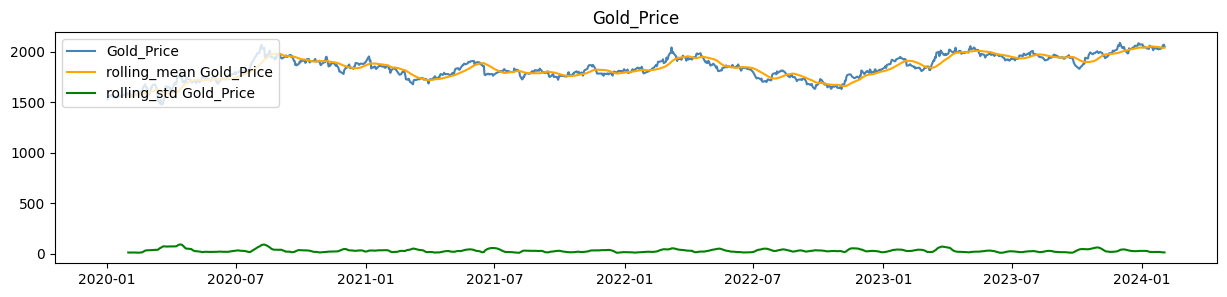

In [27]:
for col in stock_market_seven.columns:
    # зададим размер графика
    plt.figure(figsize = (15,3))
     
    # поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
    plt.plot(stock_market_seven[col], label = col, color = 'steelblue')
    plt.plot(stock_market_seven[col].rolling(window = 30).mean(), label = 'rolling_mean ' + col, color = 'orange')  
    plt.plot(stock_market_seven[col].rolling(window = 30).std(), label = 'rolling_std ' + col, color = 'green')  
    # добавим легенду, ее положение на графике и размер шрифта
    plt.legend(title = '', loc = 'upper left')
    plt.title(col)    
    # выведем обе кривые на одном графике
    plt.show()

Данные фондового рынка являются по своей природе не стационарными, что и наблюдаем на графике

Приступим к преобразованию в стационарный ряда путём самого распространённого подхода разности, суть которого заключается в  вычислении разностей между последовательными значениями временного ряда. Это позволяет удалить тренд и сезонность и привести ряд к стационарному виду. Для преобразования нестационарного ряда можно взять первую разность, вычитая из каждого значения ряда предыдущее значение. В случае необходимости, можно применить дополнительные разности, пока ряд не станет стационарным.

### Подготовка данных для обучения <a id='6'></a>

In [28]:
stock_market_seven.columns

Index(['Bitcoin_Price', 'Ethereum_Price', 'Apple_Price', 'Tesla_Price',
       'Google_Price', 'Nvidia_Price', 'Gold_Price'],
      dtype='object')

Буду работать с одним активом, чтобы потом обобщить для всех, возьму биткоин

In [29]:
stock_bit = pd.DataFrame(stock_market_seven[stock_market_seven.columns[0]])
stock_bit.head()

,Bitcoin_Price
Date,
2020-01-02,6967.000000
2020-01-03,7343.100000
2020-01-04,7481.766667
2020-01-05,7620.433333
2020-01-06,7759.100000


Ранее я делала графики на которых видно, что они не стационарны, построю гистограмму:

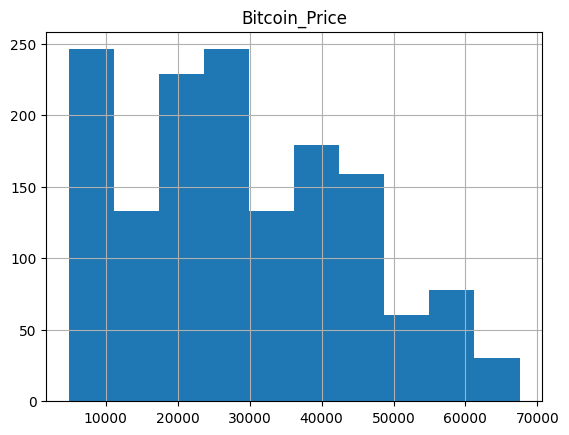

In [30]:
stock_bit.hist();

Ряд не имеет нормальное распределение. Показатели имеют не большой разброс значений, ряд у нас более менее однородный и имеет относительно небольшой разброс о чем свидетельствует коэффициент вариации: LaTeX:V = \frac {\sigma}{\bar{x}}, где LaTeX:\sigma — cреднеквадратическое отклонение, LaTeX:\bar{x} — среднее арифметическое выборки. В нашем случае он равен:

In [31]:
print('V = %f' % (stock_bit.std()/stock_bit.mean()))

V = 0.515904


Проведем тест Харки — Бера для определения нормальности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [32]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(stock_bit)
a = np.vstack([jb_test])
itog = SimpleTable(a,  row, title='тест Харки — Бера')
print(itog)

  тест Харки — Бера  
          JB         
---------------------
     68.0740687186578
1.651595904948742e-15
  0.35510386426644897
    2.231952620685513
---------------------


Значение данной статистика свидетельствует о том, нулевая гипотеза о нормальности распределения принимается (probably > 1,65...), и, следовательно, наш ряд не имеет нормального распределения. Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым не является. Поэтому для проверки проверки стационарности  проведу обобщенный тест Дикки-Фуллера на наличие единичных корней

Проверим данный актив на стационарность:

In [33]:
 
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print(f'Critical values: {result[4]}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(stock_bit['Bitcoin_Price'])

ADF Statistic: -1.6332336789474733
p-value: 0.4657985340408693
Critical values: {'1%': -3.434776133889219, '5%': -2.8634948507368767, '10%': -2.5678107418736302}
Non-Stationary


стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Повторим ещё раз.

In [34]:
stock_bit = stock_bit.diff(periods=1).dropna()
check_stationarity(stock_bit['Bitcoin_Price'])

ADF Statistic: -11.20783269611271
p-value: 2.162506642639532e-20
Critical values: {'1%': -3.434776133889219, '5%': -2.8634948507368767, '10%': -2.5678107418736302}
Stationary


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному.

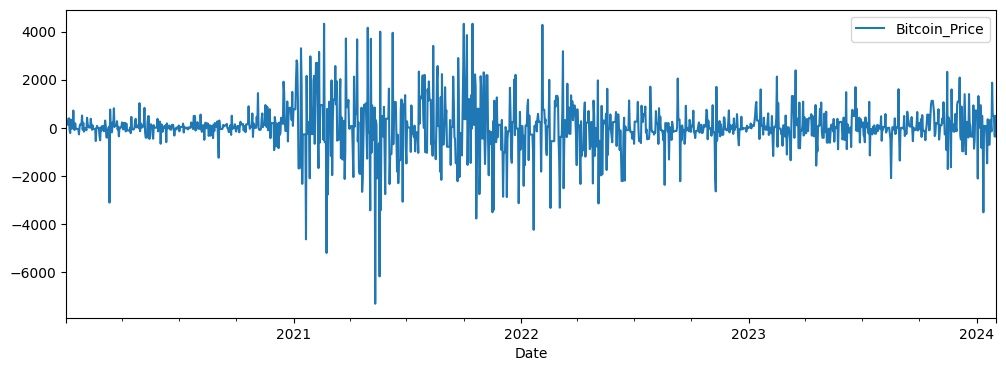

In [35]:
stock_bit.plot(figsize=(12,4));

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

Приступим к выделению признаков (День, окно, лаг и разность)

In [36]:
# Выделяем простые временные признаки
stock_bit['quarter'] = stock_bit.index.quarter
stock_bit['month'] = stock_bit.index.month
stock_bit['week'] = stock_bit.index.isocalendar().week.values
stock_bit['dayofweek'] = stock_bit.index.dayofweek

stock_bit.head()

,Bitcoin_Price,quarter,month,week,dayofweek
Date,,,,,
2020-01-03,376.100000,1,1,1,4
2020-01-04,138.666667,1,1,1,5
2020-01-05,138.666667,1,1,1,6
2020-01-06,138.666667,1,1,2,0
2020-01-07,396.600000,1,1,2,1


Так как на графике есть недельная сезон в данных, то для вычисления скользящего среднего буду использовать значение окна, равное 7 (поскольку неделя состоит из 7 дней). Это поможет учесть недельную сезонность и сгладить колебания.

Что касается лагов, то для даннямнужноно выбрать лаги, соответствующие дням неде и так как у нас недельная сезонностьти можно добавить лаги 7, 14, 21 день и т.д. Это позволит учесть цикличность данных и выявить возможные закономерности в изменениях в зависимости от дня недели.

In [37]:
# Рассчитываю скользящее (скользящее среднее)
stock_bit['rolling_window'] = stock_bit['Bitcoin_Price'].rolling(7).mean()  

# Пробегаемся циклом делаем лаги:
for i in range(1, 8):    # or 14, 21
    stock_bit['lag_' + str(i)] = stock_bit['rolling_window'].shift(i)


#Скользящее окно для расчета эксцессов
stock_bit['kurtosis'] = stock_bit['rolling_window'].rolling(7).apply(lambda x: kurtosis(x))
# Скользящее окно для расчета пиков
stock_bit['peaks'] = stock_bit['rolling_window'].rolling(7).apply(lambda x: len(find_peaks(x)[0]))
# Расширяющееся окно
stock_bit['expanding_window'] = stock_bit['rolling_window'].expanding(3).mean()

stock_bit.drop('rolling_window', axis=1, inplace=True)

In [38]:
stock_bit.head(20)

,Bitcoin_Price,quarter,month,week,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,kurtosis,peaks,expanding_window
Date,,,,,,,,,,,,,,,
2020-01-03,376.100000,1,1,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,138.666667,1,1,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,138.666667,1,1,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,138.666667,1,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,396.600000,1,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,-96.100000,1,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,-217.200000,1,1,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,344.700000,1,1,2,4,125.057143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11,-25.233333,1,1,2,5,120.571429,125.057143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.261905


In [39]:
stock_bit.tail()

,Bitcoin_Price,quarter,month,week,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,kurtosis,peaks,expanding_window
Date,,,,,,,,,,,,,,,
2024-01-29,496.166667,1,1,5,0,364.290476,193.809524,23.328571,-193.857143,-383.242857,-465.242857,-501.671429,-1.385675,0.0,22.821091
2024-01-30,-353.600000,1,1,5,1,534.771429,364.290476,193.809524,23.328571,-193.857143,-383.242857,-465.242857,-1.237563,1.0,23.100222
2024-01-31,-365.700000,1,1,5,2,436.771429,534.771429,364.290476,193.809524,23.328571,-193.857143,-383.242857,-0.797140,1.0,23.324788
2024-02-01,500.900000,1,2,5,3,356.357143,436.771429,534.771429,364.290476,193.809524,23.328571,-193.857143,-0.480117,1.0,23.611698
2024-02-02,113.300000,1,2,5,4,449.385714,356.357143,436.771429,534.771429,364.290476,193.809524,23.328571,-1.186768,2.0,23.728802


дропаем пропуски

In [40]:
stock_bit.dropna(inplace=True)

Делю данные без перемешивания, чтобы сохранялся временной ряд

In [41]:
train,  test = train_test_split(stock_bit, shuffle=False, test_size=0.2, random_state=42)

In [42]:
X_train = train.drop(['Bitcoin_Price'], axis=1)
y_train = train['Bitcoin_Price']

X_test = test.drop(['Bitcoin_Price'], axis=1)
y_test = test['Bitcoin_Price']

Данные готовы к обучению. Будем использовать классические модели машинного обучения, так как в активах присутствует сезонность и применение иных способов прогнозирования рядом, таких как ARIMA, SARIMA, SARIMAX... не будет лучше работать на этих данных.

### CatBoost   <a id='7'></a>

In [43]:
start = time.time()

splits = TimeSeriesSplit(n_splits=3)

cat = cb.CatBoostRegressor()

params_grid_cat = {'iterations': [250], 'learning_rate' : [0.1, 0.2], 'max_depth': [2, 4, 6, 10],
                   'random_state':[42],'verbose':[False]}

cat_grid =  GridSearchCV(cat, params_grid_cat, scoring='neg_root_mean_squared_error', cv=splits) 
cat_grid.fit(X_train, y_train)

end = time.time()

print('Время подбора параметров c обучением: ', end - start)


params_cat = cat_grid.best_params_
cat_score = cat_grid.score(X_train, y_train) * (-1)

print('Оптимальные параметры: ', params_cat)
print('Качество модели  CatBoost: ', cat_score)

Время подбора параметров c обучением:  31.228584051132202
Оптимальные параметры:  {'iterations': 250, 'learning_rate': 0.1, 'max_depth': 2, 'random_state': 42, 'verbose': False}
Качество модели  CatBoost:  857.1354790932214


In [44]:
print(cat_grid.cv_results_['mean_fit_time'][2])
cat_grid.cv_results_['mean_score_time'][2]

0.3006679217020671


0.0019992192586263022

In [45]:
cat_test = mean_squared_error(y_test, cat_grid.predict(X_test))**0.5

In [65]:
result_cat = pd.DataFrame([cat_grid.cv_results_['mean_fit_time'][2],  cat_test], 
    index=['Среднее время обучения, сек.', 'RMSE на test'], 
    columns=['CatBoost']
)

result_cat

,CatBoost
"Среднее время обучения, сек.",0.302000
RMSE на test,615.860391


Модель CatBoost показала хороший показатель метрики, следующей моделью попробуем LightGBM

### LightGBM <a id='8'></a>

In [59]:
start = time.time()

splits = TimeSeriesSplit(n_splits=3)

light = lgbm.sklearn.LGBMRegressor(verbose=-1)

params_grid_light = {'num_leaves': [1, 3, 5, 10, 15], 'num_iterations': [5, 10, 20, 30, 40], 
                     'max_depth': [2, 6, 8],'learning_rate':[0.01, 0.05, 0.5, 0.1, 0.2]}

light_grid = GridSearchCV(light, params_grid_light, scoring='neg_root_mean_squared_error', cv=splits, n_jobs=-1)
light_grid.fit(X_train, y_train)

end = time.time()
print('Время подбора параметров c обучением: ', end - start)

params_light = light_grid.best_params_
light_score = (light_grid.score(X_train, y_train) * (-1))

print('Оптимальные параметры: ', params_light)
print('Качество модели LightGBM: ', light_score)

Время подбора параметров c обучением:  4.930000305175781
Оптимальные параметры:  {'learning_rate': 0.1, 'max_depth': 2, 'num_iterations': 30, 'num_leaves': 5}
Качество модели LightGBM:  980.4523259063709


In [48]:
print(light_grid.cv_results_['mean_fit_time'][2])

light_grid.cv_results_['mean_score_time'][2]

0.24199970563252768


0.006333192189534505

In [61]:
light_test = mean_squared_error(y_test, light_grid.predict(X_test))**0.5

In [63]:
result_light = pd.DataFrame([light_grid.cv_results_['mean_fit_time'][2], light_test], 
    index=['Среднее время обучения, сек.',  'RMSE на test'], 
    columns=['LightGBM']
)

result_light

,LightGBM
"Среднее время обучения, сек.",0.046999
RMSE на test,596.125452


Модель также показывает хорошие результаты

### XGBRegressor <a id='9'></a>

In [51]:
start = time.time()

splits = TimeSeriesSplit(n_splits=3)

model_xgboost = XGBRegressor(random_state=42)

params_grid_xgboost = {'n_estimators': [1000, 1200], 'max_depth': [1, 2, 3],
                       'min_child_weight': [0.5, 0.7], 'learning_rate': [0.1, 0.3, 0.5]}

xgboost_grid = GridSearchCV(model_xgboost, params_grid_xgboost, scoring='neg_root_mean_squared_error', cv=splits)
xgboost_grid.fit(X_train, y_train)

end = time.time()
print('Время подбора параметров c обучением: ', end - start)

params_xgboost = xgboost_grid.best_params_
xgboost_score = xgboost_grid.best_score_ * -1
print('Оптимальные параметры: ', params_xgboost)
print('Качество модели XGBoost: ', xgboost_score)

Время подбора параметров c обучением:  43.609535455703735
Оптимальные параметры:  {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 0.5, 'n_estimators': 1000}
Качество модели XGBoost:  1157.5504413352796


In [52]:
print(xgboost_grid.cv_results_['mean_fit_time'][2])

xgboost_grid.cv_results_['mean_score_time'][2]

0.2673331101735433


0.006334702173868815

In [53]:
xgboost_test = mean_squared_error(y_test, xgboost_grid.predict(X_test))**0.5

In [64]:
result_xgboost = pd.DataFrame([xgboost_grid.cv_results_['mean_fit_time'][2], xgboost_test], 
    index=['Среднее время обучения, сек.', 'RMSE на test'], 
    columns=['XGBRegressor']
)

result_xgboost

,XGBRegressor
"Среднее время обучения, сек.",0.269333
RMSE на test,628.144368


Для модели XGBRegressor качество на обучении не достигает уровня предыдущих моделей бустинга, но так как сам фондовый рынок не предсказуем по поведению учесть всё мы не можем. Поэтому считаю что модели бустинга справились хорошо. Для наглядности обобщим полученные результаты обучения:

##### РЕЗУЛЬТАТЫ ОБУЧЕНИЯ И ПРЕДСКАЗАНИЙ МОДЕЛЕЙ

In [66]:
result_xgboost.join([result_light, result_cat])

,XGBRegressor,LightGBM,CatBoost
"Среднее время обучения, сек.",0.269333,0.046999,0.302000
RMSE на test,628.144368,596.125452,615.860391


### Тестирование  <a id='10'></a>

Отрисую на графике результаты на тестовых данных по моделям CatBoost, LightGBM и XGBRegressor

In [56]:
    light_grid = GridSearchCV(light, params_grid_light, scoring='neg_root_mean_squared_error', cv=splits, n_jobs=-1)

    # XGBRegressor
    model_xgboost = XGBRegressor(random_state=42)

    params_grid_xgboost = {'n_estimators': [1000, 1200], 'max_depth': [1, 2, 3],
                           'min_child_weight': [0.5, 0.7], 'learning_rate': [0.1, 0.3, 0.5]}

    xgboost_grid = GridSearchCV(model_xgboost, params_grid_xgboost, scoring='neg_root_mean_squared_error', cv=splits)

    print('Расчётный актив:', col[i])
    models = [cat_grid, light_grid, xgboost_grid]
    name_model = ['CatBoostRegressor', 'LGBMRegressor', 'XGBRegressor']
    for model, model_name in zip(models, name_model):
        model.fit(X_train, y_train)
        RMSE = mean_squared_error(y_test, model.predict(X_test))**0.5
        print(f'RMSE на тесте для модели {model_name}: {RMSE}')
    print('\n')

Расчётный актив: i
RMSE на тесте для модели CatBoostRegressor: 615.8603914409182
RMSE на тесте для модели LGBMRegressor: 596.1254523300825
RMSE на тесте для модели XGBRegressor: 628.1443678288853




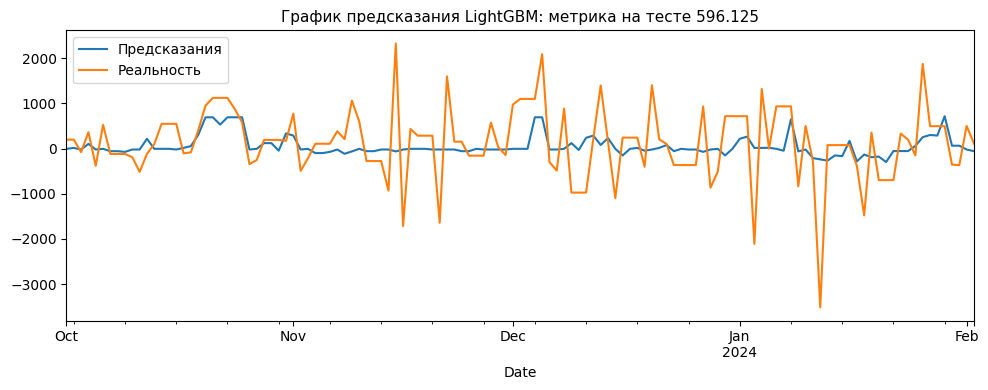

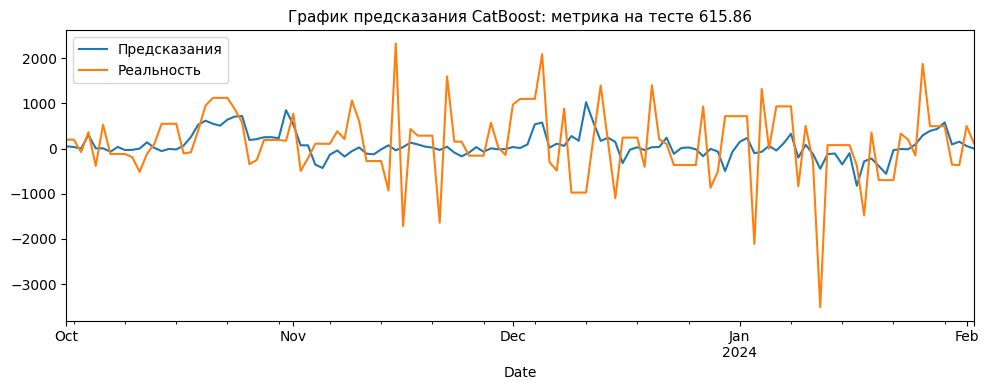

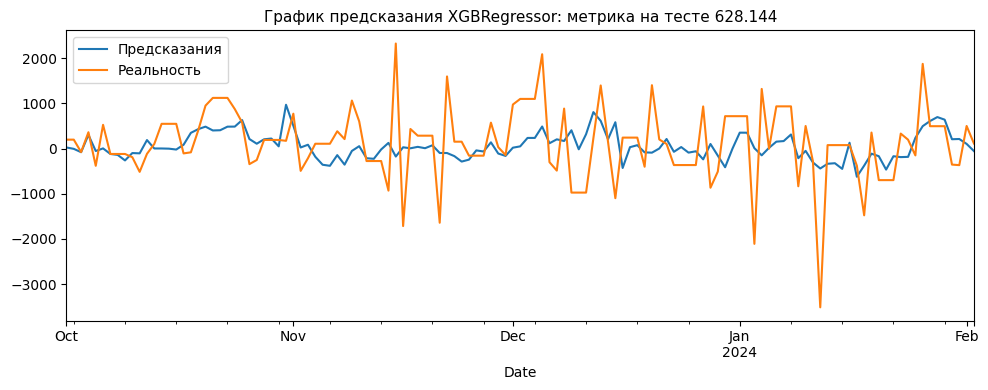

In [57]:
model_lst = [light_grid, cat_grid, xgboost_grid]
model_name = ['LightGBM', 'CatBoost', 'XGBRegressor']
num=0
for model in model_lst:    
    RMSE = pd.Series(model.predict(X_test), index = y_test.index)
    RMSE_metric = mean_squared_error(y_test, model.predict(X_test))**0.5
    plt.figure(figsize=(10, 4))
    plt.title(f'График предсказания {model_name[num]}: метрика на тесте {round(RMSE_metric, 3)}', fontsize=11)
    RMSE.plot(label = 'Предсказания')
    y_test.plot(label = 'Реальность')
    plt.xlim(['2023-10-01','2024-02-02'])
    plt.legend()
    plt.tight_layout()
    num+=1

### 

В ходе работы я брала данные с фондового рынка, в которых сделала ресемплинг по дням, подготовила к анализу данные, посмотрела на тренд, сезонность. В активах есть недельная сезонность, шум. Данные не стационарны на фондовом рынке по своей природе, поэтому привела ряд к стационарному.

Далее были построены модели для прогнозирования активов рынка с помощью моделей  CatBoost, LightGBM и XGBRegressor.

Целью стояло подготовить модель с меньшей метрикой. С данной задачью справились  LightGBM, CatBoost, но модель LightGBM показала лучшие результаты на трейне и тесте, возможно и CatBoost был бы более хорош, подобрав более оптимальные параметры, списывать его со счетов не стоит.

По итогу проведённой работы выбрана перспективную модель LightGBM для прогнозирования цен на фондовом рынке в разрезк активов. Но стоит помнить, что предсказать рост и падение на фондовом рынке не так и просто и над этой задачей кропотливо работают тысячи, если не больше, компаний. Считаю, что на краткосрочной перспективе можно брать модель машинного обучения, но если к примеру проанализировать полученные метрики с расчётом коэффициента детерминации видно будет, что коэффициент будет мал, а значит ML тут не способен точно прогнозировать тенденции на рынке. Возможно дополнительный сбор данных (за более короткие промежутки времени) поможет скорректировать качество полученных моделей, но к сожалению их нет в общедоступности.